<h1 align=center>Medical Image Analysis</h1>

## Import libraries

In [2]:
try:
  import pydicom
except:
  !pip install pydicom
  import pydicom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import os

import cv2
from PIL import Image

import tensorflow as tf

## Downlaod dataset directly from kaggle to colab and creating the following structure
Example of file structure
```
images
└───train <- training images
│   └───have
│   │   │   ---.jpeg
│   │   │   ---.jpeg
│   │   │   ...      
│   └───have_not
│       │   ---.jpeg
│       │   ---.jpeg
│       │   ...
│   
└───val <- testing images
│   └───have
│   │   │   ---.jpeg
│   │   │   ---.jpeg
│   │   │   ...      
│   └───have_not
│       │   ---.jpeg
│       │   ---.jpeg
│       │   ...
```

### Download the dataset

**import kaggle.json to google colab**

In [2]:
!chmod 600 /content/kaggle.json #how to keep our api key unavailabe to others

In [3]:
# Get data directly from kaggle
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [00:42<00:00, 98.3MB/s]
100% 3.66G/3.66G [00:42<00:00, 92.5MB/s]


### unzip the dataset

In [4]:
import zipfile

data = zipfile.ZipFile("rsna-pneumonia-detection-challenge.zip")
data.extractall()
data.close()

## Data Loading And EDA

In [5]:
df = pd.read_csv("stage_2_train_labels.csv")
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [6]:
df.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [8]:
## check the null values
df.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [9]:
## check balance of the target column
df.Target.value_counts(normalize=True)

Target
0    0.683892
1    0.316108
Name: proportion, dtype: float64

In [10]:
## removing diplicate patient
df = df.drop_duplicates("patientId")

In [11]:
ROOT_PATH = Path("stage_2_train_images/")

In [12]:
df.patientId.iloc[0]

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

*display the images (dicom)*

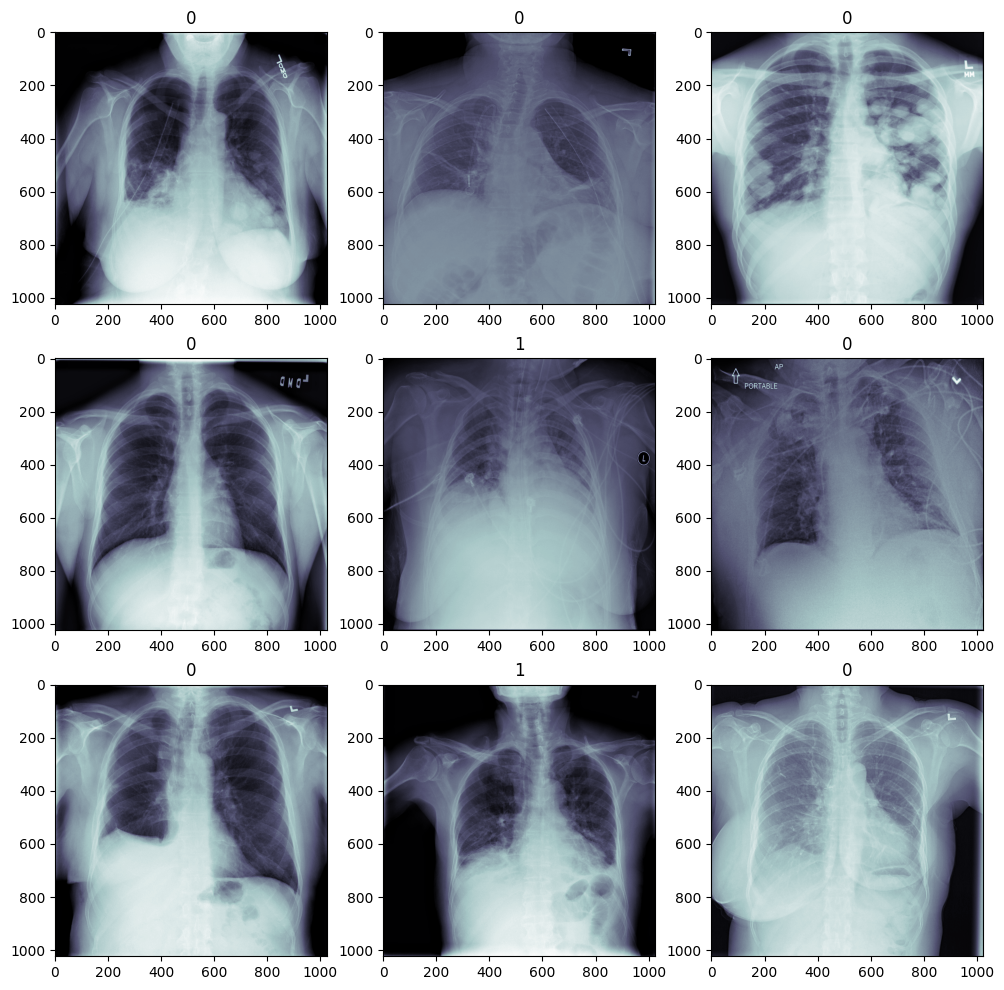

In [13]:
fig, axis = plt.subplots(3, 3, figsize=(12, 12))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = df.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id # Create the path to the dcm file
        dcm_path = dcm_path.with_suffix(".dcm") # adding .dcm suffix
        dcm = pydicom.read_file(dcm_path).pixel_array # read the dicom file

        label = df["Target"].iloc[c]

        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

## Feature Engineering

### Covert dicom files to jpeg

In [14]:
df.Target.value_counts()

Target
0    20672
1     6012
Name: count, dtype: int64

In [15]:
train = os.listdir("/content/stage_2_train_images")
train[:2]

['cab1fcd3-7e67-4928-8612-80bae540ca2c.dcm',
 '14e97471-0144-42a2-9b7d-1b0f7d3a77b7.dcm']

In [16]:
len(train)

26684

In [17]:
os.makedirs("./images", exist_ok=True)
os.makedirs("./images/train", exist_ok=True)
os.makedirs("./images/val", exist_ok=True)
os.makedirs("./images/train/have", exist_ok=True)
os.makedirs("./images/train/have_not", exist_ok=True)
os.makedirs("./images/val/have", exist_ok=True)
os.makedirs("./images/val/have_not", exist_ok=True)

for c,i in enumerate(tqdm(train)):
  ds = pydicom.dcmread(r"stage_2_train_images/" + i)
  name = i.split(".")[0]
  img = Image.fromarray(ds.pixel_array)
  tar = df[df.patientId == name].values[0][5]
  if tar == 0:
    train_or_val = "train" if c < 24000 else "val"
    img.save("./images/"+ train_or_val + "/have/" + name + ".jpeg")
  else:
    train_or_val = "train" if c < 24000 else "val"
    img.save("./images/"+ train_or_val + "/have_not/" + name + ".jpeg")

  0%|          | 0/26684 [00:00<?, ?it/s]

In [18]:
for dirpath, dirnames, filenames in os.walk("images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'images'.
There are 2 directories and 0 images in 'images/train'.
There are 0 directories and 5392 images in 'images/train/have_not'.
There are 0 directories and 18608 images in 'images/train/have'.
There are 2 directories and 0 images in 'images/val'.
There are 0 directories and 620 images in 'images/val/have_not'.
There are 0 directories and 2064 images in 'images/val/have'.


In [21]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):

  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  # img = cv2.imread(target_folder + "/" + random_image[0])
  img = mpimg.imread(target_folder + "/" + random_image[0])

  plt.figure(figsize=(14,10))
  plt.imshow(img, cmap="bone")
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (1024, 1024)


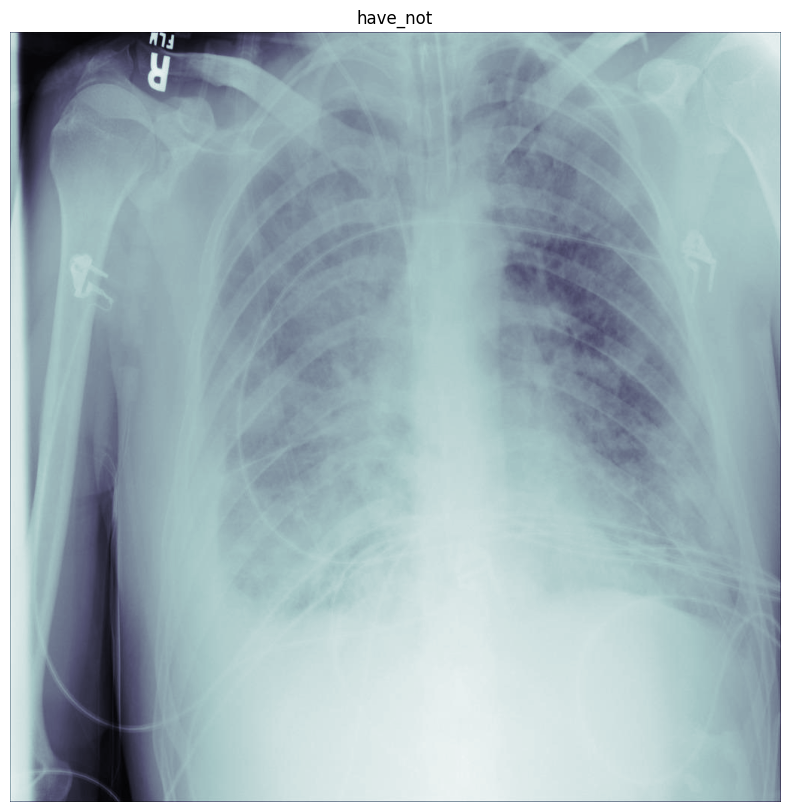

In [22]:
# View a random image from the training dataset
img = view_random_image(target_dir="images/train/",
                        target_class="have_not")

### create a sample data

In [19]:
"""
os.makedirs("./train", exist_ok=True)
os.makedirs("./train/have", exist_ok=True)
os.makedirs("./train/have_not", exist_ok=True)


for c,i in enumerate(tqdm(train)):
  ds = pydicom.dcmread(r"/content/dataset/stage_2_train_images/" + i)
  name = i.split(".")[0]
  img = Image.fromarray(ds.pixel_array)
  tar = df[df.patientId == name].values[0][5]

  if tar == 0:
    img.save("./train/have_not/" + name + ".jpeg")
  else:
    img.save("./train/have/" + name + ".jpeg")


  if c == 400:
    break
"""

'\nos.makedirs("./train", exist_ok=True)\nos.makedirs("./train/have", exist_ok=True)\nos.makedirs("./train/have_not", exist_ok=True)\n\n\nfor c,i in enumerate(tqdm(train)):\n  ds = pydicom.dcmread(r"/content/dataset/stage_2_train_images/" + i)\n  name = i.split(".")[0]\n  img = Image.fromarray(ds.pixel_array)\n  tar = df[df.patientId == name].values[0][5]\n\n  if tar == 0:\n    img.save("./train/have_not/" + name + ".jpeg")\n  else:\n    img.save("./train/have/" + name + ".jpeg")\n\n\n  if c == 400:\n    break\n'

In [ ]:
## Python script that uses the shutil library to copy n images from source to destination
import os
import shutil
import random

def copy_images(source_dir, dest_dir, num_images):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    all_images = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    selected_images = random.sample(all_images, num_images)

    for image in selected_images:
        src_path = os.path.join(source_dir, image)
        dest_path = os.path.join(dest_dir, image)
        shutil.copy(src_path, dest_path)
        # print(f"Copied {image} to {dest_dir}")

In [46]:
## train dataset samples

# Source and destination directories
source_dir_have = 'images/train/have'
dest_dir_have = 'RSNA/train/have'

source_dir_have_not = 'images/train/have_not'
dest_dir_have_not = 'RSNA/train/have_not'

# Number of images to copy
num_images_to_copy = 200

# Copying images
copy_images(source_dir_have, dest_dir_have, num_images_to_copy)
copy_images(source_dir_have_not, dest_dir_have_not, num_images_to_copy)

print("Copying train completed.")

Copying train completed.


In [47]:
## valid dataset samples

# Source and destination directories
source_dir_have = 'images/val/have'
dest_dir_have = 'RSNA/val/have'

source_dir_have_not = 'images/val/have_not'
dest_dir_have_not = 'RSNA/val/have_not'

# Number of images to copy
num_images_to_copy = 100

# Copying images
copy_images(source_dir_have, dest_dir_have, num_images_to_copy)
copy_images(source_dir_have_not, dest_dir_have_not, num_images_to_copy)

print("Copying validation completed.")

Copying validation completed.


In [48]:
for dirpath, dirnames, filenames in os.walk("RSNA"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'RSNA'.
There are 2 directories and 0 images in 'RSNA/train'.
There are 0 directories and 200 images in 'RSNA/train/have_not'.
There are 0 directories and 200 images in 'RSNA/train/have'.
There are 2 directories and 0 images in 'RSNA/val'.
There are 0 directories and 100 images in 'RSNA/val/have_not'.
There are 0 directories and 100 images in 'RSNA/val/have'.


**zip the sample dataset directory**

In [50]:
import shutil
import os

def zip_directory(directory_path, output_path):
    # Ensure the output path does not have a trailing slash or backslash
    output_path = output_path.rstrip('/\\')
    # Create the archive
    shutil.make_archive(output_path, 'zip', directory_path)
    print(f"Directory '{directory_path}' has been zipped into '{output_path}.zip'")


directory_to_zip = 'RSNA'
output_zip_file = 'RSNA'  # Do not include '.zip' extension

zip_directory(directory_to_zip, output_zip_file)


Directory 'RSNA' has been zipped into 'RSNA.zip'


**Download the zip directory to lacal disk**

In [51]:
from google.colab import files

# Path to the zip file
zip_file_path = 'RSNA.zip'

# Download the zip file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### using tf.data.dataset api

The `tf.data.Dataset` API in TensorFlow is used for building complex input pipelines from simple, reusable pieces. This API enables efficient and easy handling of large datasets, including preprocessing, augmentation, shuffling, and batching.

In [23]:
train_dir = "images/train/"
test_dir = "images/val/"

In [24]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="binary",
                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="binary",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 24000 files belonging to 2 classes.
Found 2684 files belonging to 2 classes.


## Train Section
- train the model on entire dataset

In [25]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = base_model(inputs, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256  

In [27]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5,
                                              monitor='val_loss',
                                              verbose=0)

In [28]:
# Compile
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["accuracy"])

# Fit
history = model.fit(train_data,
                    epochs=20,
                    validation_data=test_data,
                    validation_steps=int(len(test_data)),
                    callbacks=[early_stop])

Epoch 1/20
750/750 [==============================] - 150s 177ms/step - loss: 0.4212 - accuracy: 0.8018 - val_loss: 0.3914 - val_accuracy: 0.8145
Epoch 2/20
750/750 [==============================] - 108s 143ms/step - loss: 0.3946 - accuracy: 0.8173 - val_loss: 0.3841 - val_accuracy: 0.8189
Epoch 3/20
750/750 [==============================] - 107s 142ms/step - loss: 0.3842 - accuracy: 0.8238 - val_loss: 0.3864 - val_accuracy: 0.8197
Epoch 4/20
750/750 [==============================] - 106s 140ms/step - loss: 0.3744 - accuracy: 0.8302 - val_loss: 0.3886 - val_accuracy: 0.8159
Epoch 5/20
750/750 [==============================] - 107s 142ms/step - loss: 0.3678 - accuracy: 0.8319 - val_loss: 0.4127 - val_accuracy: 0.8208
Epoch 6/20
750/750 [==============================] - 105s 139ms/step - loss: 0.3620 - accuracy: 0.8378 - val_loss: 0.4017 - val_accuracy: 0.8215
Epoch 7/20
750/750 [==============================] - 109s 144ms/step - loss: 0.3535 - accuracy: 0.8409 - val_loss: 0.4186 -

In [29]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

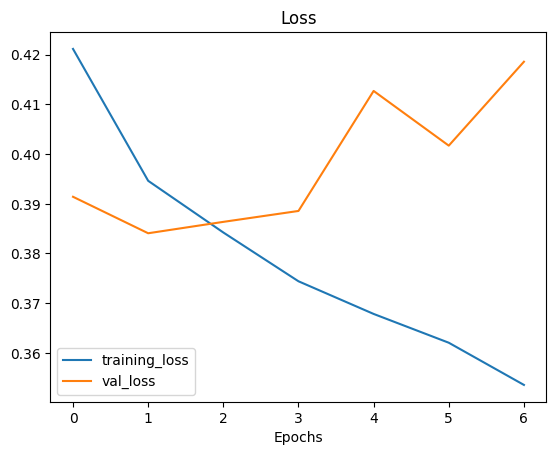

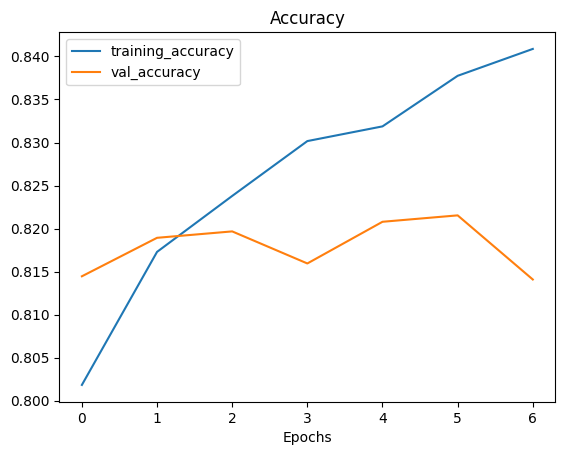

In [30]:
plot_loss_curves(history)

In [31]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling True float32 <Policy "float32">
dense True float32 <Policy "float32">
dense_1 True float32 <Policy "float32">
dense_2 True float32 <Policy "float32">
output_layer True float32 <Policy "float32">


In [32]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
rescaling_1 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


In [33]:
model.layers

In [34]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [35]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [36]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [37]:
# Fine tune for another 5 epochs
initial_epochs = 10
fine_tune_epochs = initial_epochs + 5

history_fine = model.fit(train_data,
                         epochs=fine_tune_epochs,
                         validation_data=test_data,
                         initial_epoch=history.epoch[-1], # start from previous last epoch
                         validation_steps=int(0.25 * len(test_data)),
                         callbacks=[early_stop])

Epoch 7/15
750/750 [==============================] - 116s 140ms/step - loss: 0.3521 - accuracy: 0.8407 - val_loss: 0.1367 - val_accuracy: 0.9643
Epoch 8/15
750/750 [==============================] - 100s 133ms/step - loss: 0.3287 - accuracy: 0.8524 - val_loss: 0.2385 - val_accuracy: 0.9152
Epoch 9/15
750/750 [==============================] - 101s 134ms/step - loss: 0.3094 - accuracy: 0.8629 - val_loss: 0.1859 - val_accuracy: 0.9345
Epoch 10/15
750/750 [==============================] - 107s 141ms/step - loss: 0.2836 - accuracy: 0.8779 - val_loss: 0.2583 - val_accuracy: 0.9167
Epoch 11/15
750/750 [==============================] - 108s 142ms/step - loss: 0.2524 - accuracy: 0.8924 - val_loss: 0.2471 - val_accuracy: 0.9345
Epoch 12/15
750/750 [==============================] - 105s 139ms/step - loss: 0.2250 - accuracy: 0.9054 - val_loss: 0.4128 - val_accuracy: 0.8586


In [40]:
results_fine_tunning_model = model.evaluate(test_data)
results_fine_tunning_model

84/84 [==============================] - 10s 119ms/step - loss: 0.5375 - accuracy: 0.8070


[0.5375499725341797, 0.807004451751709]

In [38]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


7
13
[0.8018333315849304, 0.8172916769981384, 0.8237916827201843, 0.8301666378974915, 0.8318750262260437, 0.8377500176429749, 0.8408750295639038, 0.840666651725769, 0.8523749709129333, 0.8628749847412109, 0.877916693687439, 0.8924166560173035, 0.9053750038146973]


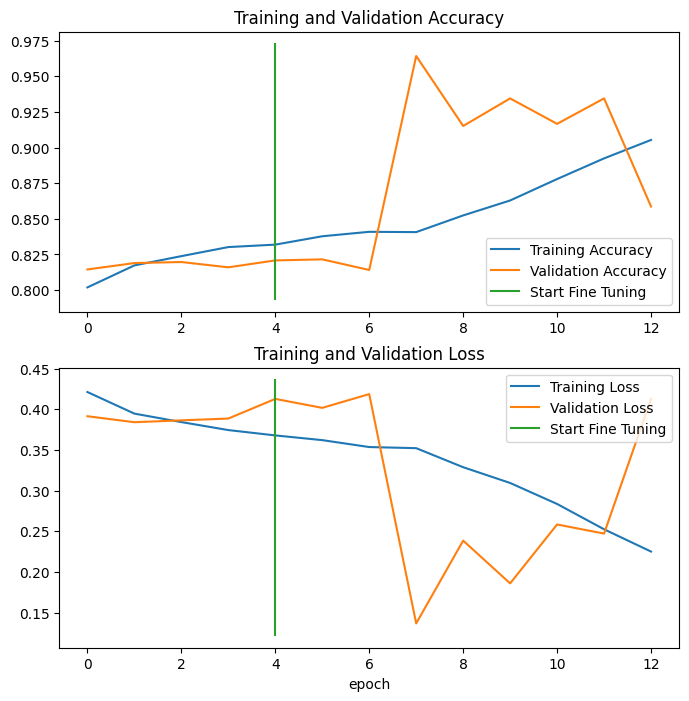

In [39]:
compare_historys(original_history=history,
                 new_history=history_fine,
                 initial_epochs=5)